In [3]:
##Latest notebook visualizing results for Distribution Paper by Julia Geller
##Updated:  07/02/2022

# Required to access the database
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"


import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# Data analysis tools
import pandas as pd
import numpy as np
import seaborn as sns

# Models available in our application
from datasets.models import RawFlower, RawUNM, RawDAR, RawNHANES_BIO
from django.contrib.auth.models import User
from datasets.models import RawDictionary


from datasets.models import RawNEU
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels

from api import adapters

In [4]:
##merges 4 cohorts based on columns in common
def merge4CohortFrames2(df1, df2, df3,df4):
    'merge on feature intersections'

    for as_feature in ['UASB', 'UDMA', 'UAS5', 'UIAS', 'UAS3', 'UMMA']:
        if as_feature not in df1.columns:
            df1[as_feature] = np.nan
        if as_feature not in df2.columns:
            df2[as_feature] = np.nan
        if as_feature not in df3.columns:
            df3[as_feature] = np.nan

    s1 = set(df1.columns)
    s2 = set(df2.columns)
    s3 = set(df3.columns)
    s4 = set(df4.columns)

    cc = set.intersection(s1, s2, s3,s4)

    df_all = pd.concat([df1[cc],df2[cc],df3[cc], df4[cc]])

    return (df_all, cc)

In [6]:
##Create aliases
NEU_alias = 'PROTECT'
DAR_alias = 'NHBCS'
UNM_alias = 'Navajo'
NHANES_alias = 'NHANES' 
## Get the data

## NEU (Cohort 1)
df_NEU = adapters.neu.get_dataframe_orig()
df_NEU = df_NEU[df_NEU['TimePeriod']==2] # Visit 2

NEU_covars = adapters.neu.get_dataframe_covars()
df_NEU_covars = NEU_covars.merge(df_NEU, on = ['PIN_Patient','CohortType','TimePeriod']) #Merge the covariates
df_NEU['CohortType'] = NEU_alias

df_NEU_blod = adapters.neu.get_dataframe_BLOD()
df_NEU_blod['CohortType'] = NEU_alias
df_NEU_blod = df_NEU_blod[df_NEU_blod['TimePeriod']==2]


##DAR (Cohort 2)

df_DAR = adapters.dar.get_dataframe()

df_DAR_blod = adapters.dar.get_dataframe_BLOD()
df_DAR_blod['CohortType'] = DAR_alias

''''DAR_covars = adapters.dar.get_dataframe_covars()
df_DAR_covars = DAR_covars.merge(df_DAR, on = ['PIN_Patient','CohortType','TimePeriod']) #Merge the covariates
'''
df_DAR['CohortType'] = DAR_alias


'''

df_UNM = adapters.unm.get_dataframe_orig()

df_UNM_blod = adapters.unm.get_dataframe_BLOD()
df_UNM_blod['CohortType'] = UNM_alias

UNM_covars = adapters.unm.get_dataframe_covars()
df_UNM_covars = UNM_covars.merge(df_UNM, on = ['PIN_Patient','CohortType','TimePeriod']) #Merge the covariates
df_UNM['CohortType'] = UNM_alias
'''

##!!DELETE FOR WHEN FINALIZING RESULTS 
df_UNM = df_NEU.copy()
df_UNM['CohortType'] = UNM_alias
df_UNM_blod = df_NEU_blod.copy()
df_UNM_blod['CohortType'] = UNM_alias


##NHANES 

df_NHANES = adapters.nhanes.get_dataframe_orig()
df_NHANES = df_NHANES.rename_axis(None, axis=1)

df_NHANES_blod = adapters.nhanes.get_dataframe_orig_blod()

NHANES_covars = adapters.nhanes.get_dataframe_covars()
##df_NHANES_covars = NHANES_covars.merge(df_NHANES, on = ['PIN_Patient','CohortType','TimePeriod'])
df_NHANES['CohortType'] = NHANES_alias
df_NHANES_blod['CohortType'] = NHANES_alias

df_ALL, intersec_cols = merge4CohortFrames2(df_NEU, df_UNM, df_DAR, df_NHANES)


## df_ALL = analysis.merge3CohortFrames(df_NEU, df_UNM, df_DAR)
frames_for_analysis = [
    (NEU_alias, df_NEU),
    (DAR_alias, df_DAR),
    (UNM_alias, df_UNM),
    (NHANES_alias, df_NHANES),
    ('ALL', df_ALL)

]

for name, df in frames_for_analysis:
    print('Data Stats')
    print(name)
    print(df.shape)

Data Stats
PROTECT
(570, 32)
Data Stats
NHBCS
(2152, 198)
Data Stats
Navajo
(570, 32)
Data Stats
NHANES
(8583, 22)
Data Stats
ALL
(11875, 17)


In [7]:
df_NHANES_blod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8652 entries, 0 to 8651
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PIN_Patient  8652 non-null   int64  
 1   TimePeriod   8652 non-null   object 
 2   UALB_mg      6376 non-null   float64
 3   UALB_ug      6376 non-null   float64
 4   UBA          2893 non-null   float64
 5   UCD          2893 non-null   float64
 6   UCO          2893 non-null   float64
 7   UCR          621 non-null    float64
 8   UCRT_mg      4055 non-null   float64
 9   UCRT_umol    4055 non-null   float64
 10  UCS          2893 non-null   float64
 11  UHG          2895 non-null   float64
 12  UI           1354 non-null   float64
 13  UMN          2893 non-null   float64
 14  UMO          2892 non-null   float64
 15  UNI          621 non-null    float64
 16  UPB          2893 non-null   float64
 17  USB          2893 non-null   float64
 18  USN          2892 non-null   float64
 19  UTL   

**Summary Statistics**

In [113]:
##limit summary statistic values to two decimal places
def clean_cols(desc_DF):
    desc_DF["count"]=desc_DF["count"].astype(int)
    desc_DF["mean"]=round(desc_DF["mean"],2)
    desc_DF["std"]=round(desc_DF["std"],2)
    desc_DF["min"]=round(desc_DF["min"],2)
    desc_DF["25%"]=round(desc_DF["25%"],2)
    desc_DF["50%"]=round(desc_DF["50%"],2)
    desc_DF["75%"]=round(desc_DF["75%"],2)
    desc_DF["max"]=round(desc_DF["max"],2)

def desc_4_cohs(df_neu, df_dar, df_unm, df_nhanes, fi_name):
    ##columns to describe
    desc_cols = []
    for col in df_ALL.columns:
        if col not in ['PIN_Patient', 'TimePeriod', 'CohortType']:
            desc_cols.append(col)
    # NEU
    desc_neu = df_neu[desc_cols].describe().transpose()
    clean_cols(desc_neu)

    # DAR 
    desc_dar = df_dar[desc_cols].describe().transpose()
    clean_cols(desc_dar)

    # UNM
    desc_unm = df_unm[desc_cols].describe().transpose()
    clean_cols(desc_unm)

    # NHANES
    desc_nhanes = df_nhanes[desc_cols].describe().transpose()
    clean_cols(desc_nhanes)

    #Saving each summary dataframe to a csv file.
    frames_names = [(desc_neu,NEU_alias), (desc_dar, DAR_alias),(desc_unm, UNM_alias), (desc_nhanes,NHANES_alias)]


    try:
        f = open(fi_name+".csv", "x")
        f = open(fi_name+".csv", "a")

    except:
        f = open(fi_name+".csv", "a")

    for tup in frames_names:
        frame=tup[0]
        latex_frame=tup[0].to_latex()
        name=tup[1]
        ##content=string(name ,"/n",frame,"\n\n")
        f.write(name + ',')
        f.write("\n\t")
        f.write(str(frame) + ',')
        f.write("\n\n")
        f.write(latex_frame)

    f.close()
    return frames_names, desc_cols


In [114]:
frames_names, desc_cols = desc_4_cohs(df_NEU, df_DAR, df_UNM, df_NHANES, "Summary_Stats_DP_Paper_JGeller")

In [10]:
def df_to_log_cols(df, intersec):
    df_res = df.copy()
    for col in intersec:
        if col not in ['CohortType','PIN_Patient', 'TimePeriod']:
            df_res[col] = np.log10(df[col])
    return df_res

In [11]:
df_NEU_log = df_to_log_cols(df_NEU, intersec_cols)
df_NEU_log[intersec_cols].head(5)

/usr/local/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Analyte,UTL,USB,UCS,PIN_Patient,TimePeriod,UNI,CohortType,UHG,UTU,UMO,UMN,UBA,USN,UCD,UCR,UPB,UCO
1,-0.684315,-0.730192,0.758474,1001,2,0.956338,PROTECT,0.156531,-0.782599,2.280897,0.142206,0.492494,0.209582,-0.570745,0.423224,-0.001695,0.133517
4,-0.638868,-0.662629,0.879895,1006,2,0.796820,PROTECT,0.157989,-0.851180,1.994594,0.212745,0.375222,0.878280,-0.715890,-0.056112,-0.132991,0.053285
5,-0.497995,-0.918591,0.476797,1014,2,0.622948,PROTECT,0.240249,-0.654998,1.586841,0.040129,0.207131,0.492827,-0.919290,-0.701935,-0.700717,-0.176996
7,-0.497108,-0.914476,0.921960,1015,2,0.949696,PROTECT,0.378366,-0.225001,2.052919,0.009176,1.080958,0.915049,-0.855023,0.205681,-0.032481,0.447858
10,-0.773186,-0.813160,0.599358,1021,2,0.420111,PROTECT,-0.571207,-0.224902,1.554722,-0.187473,0.180769,0.327922,-0.932181,-0.280967,-0.205658,0.018995


In [12]:
df_NEU[intersec_cols].head(5)

Analyte,UTL,USB,UCS,PIN_Patient,TimePeriod,UNI,CohortType,UHG,UTU,UMO,UMN,UBA,USN,UCD,UCR,UPB,UCO
1,0.206864,0.186127,5.734215,1001,2,9.043525,PROTECT,1.433939,0.164969,190.940042,1.387413,3.108090,1.620250,0.268692,2.649865,0.996104,1.359932
4,0.229685,0.217456,7.583948,1006,2,6.263543,PROTECT,1.438763,0.140870,98.762827,1.632094,2.372585,7.555786,0.192358,0.878795,0.736223,1.130538
5,0.317691,0.120617,2.997761,1014,2,4.197086,PROTECT,1.738799,0.221310,38.622516,1.096803,1.611131,3.110478,0.120423,0.198639,0.199197,0.665280
7,0.318341,0.121765,8.355262,1015,2,8.906274,PROTECT,2.389822,0.595660,112.958633,1.021353,12.049190,8.223358,0.139629,1.605763,0.927939,2.804516
10,0.168583,0.153759,3.975187,1021,2,2.630937,PROTECT,0.268407,0.595796,35.869254,0.649422,1.516245,2.127759,0.116901,0.523640,0.622791,1.044709


In [13]:
df_DAR_log = df_to_log_cols(df_DAR, intersec_cols)
df_DAR_log[intersec_cols].head(5)

,UTL,USB,UCS,PIN_Patient,TimePeriod,UNI,CohortType,UHG,UTU,UMO,UMN,UBA,USN,UCD,UCR,UPB,UCO
0,-2.849485,-1.688246,NaN,3a57b2dc-3de5-48f5-8d2c-69aa6cbdeb70,1,0.185117,NHBCS,-0.923745,NaN,1.750115,-0.688246,NaN,-0.010105,-1.709965,-0.829641,-0.568636,-1.263603
1,-2.849485,-2.096910,NaN,e3cc165b-52da-4ded-a620-aea00104a837,1,-0.974424,NHBCS,-1.053605,NaN,1.407985,-0.603801,NaN,-0.430626,-1.292430,-0.974424,-0.701147,-0.856985
2,NaN,NaN,NaN,3a237a4d-6d2b-4dc7-ab84-fd369055f886,1,NaN,NHBCS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-2.849485,-1.886057,NaN,7a350353-cbde-468e-9f23-8dd50ac7bcd8,1,0.115611,NHBCS,-0.477556,NaN,1.981923,-1.673394,NaN,-0.112383,-1.468521,-0.974424,-2.372364,0.190051
4,-2.849485,-1.309804,NaN,c9a26e31-7aa5-46d2-9fa6-24550e47e92c,1,-0.221849,NHBCS,-2.000000,NaN,2.057670,-0.073658,NaN,-0.359519,-0.696804,-0.974424,-0.166853,0.215373


In [14]:
df_DAR[intersec_cols].head(5)

,UTL,USB,UCS,PIN_Patient,TimePeriod,UNI,CohortType,UHG,UTU,UMO,UMN,UBA,USN,UCD,UCR,UPB,UCO
0,0.001414,0.0205,NaN,3a57b2dc-3de5-48f5-8d2c-69aa6cbdeb70,1,1.531500,NHBCS,0.119194,NaN,56.249,0.205000,NaN,0.977,0.0195,0.148033,0.270000,0.0545
1,0.001414,0.0080,NaN,e3cc165b-52da-4ded-a620-aea00104a837,1,0.106066,NHBCS,0.088388,NaN,25.585,0.249000,NaN,0.371,0.0510,0.106066,0.199000,0.1390
2,NaN,NaN,NaN,3a237a4d-6d2b-4dc7-ab84-fd369055f886,1,NaN,NHBCS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.001414,0.0130,NaN,7a350353-cbde-468e-9f23-8dd50ac7bcd8,1,1.305000,NHBCS,0.333000,NaN,95.923,0.021213,NaN,0.772,0.0340,0.106066,0.004243,1.5490
4,0.001414,0.0490,NaN,c9a26e31-7aa5-46d2-9fa6-24550e47e92c,1,0.600000,NHBCS,0.010000,NaN,114.201,0.844000,NaN,0.437,0.2010,0.106066,0.681000,1.6420


In [15]:
df_UNM_log = df_to_log_cols(df_UNM, intersec_cols)
df_UNM_log[intersec_cols].head(5)

/usr/local/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Analyte,UTL,USB,UCS,PIN_Patient,TimePeriod,UNI,CohortType,UHG,UTU,UMO,UMN,UBA,USN,UCD,UCR,UPB,UCO
1,-0.684315,-0.730192,0.758474,1001,2,0.956338,Navajo,0.156531,-0.782599,2.280897,0.142206,0.492494,0.209582,-0.570745,0.423224,-0.001695,0.133517
4,-0.638868,-0.662629,0.879895,1006,2,0.796820,Navajo,0.157989,-0.851180,1.994594,0.212745,0.375222,0.878280,-0.715890,-0.056112,-0.132991,0.053285
5,-0.497995,-0.918591,0.476797,1014,2,0.622948,Navajo,0.240249,-0.654998,1.586841,0.040129,0.207131,0.492827,-0.919290,-0.701935,-0.700717,-0.176996
7,-0.497108,-0.914476,0.921960,1015,2,0.949696,Navajo,0.378366,-0.225001,2.052919,0.009176,1.080958,0.915049,-0.855023,0.205681,-0.032481,0.447858
10,-0.773186,-0.813160,0.599358,1021,2,0.420111,Navajo,-0.571207,-0.224902,1.554722,-0.187473,0.180769,0.327922,-0.932181,-0.280967,-0.205658,0.018995


In [16]:
df_UNM[intersec_cols].head(5)

Analyte,UTL,USB,UCS,PIN_Patient,TimePeriod,UNI,CohortType,UHG,UTU,UMO,UMN,UBA,USN,UCD,UCR,UPB,UCO
1,0.206864,0.186127,5.734215,1001,2,9.043525,Navajo,1.433939,0.164969,190.940042,1.387413,3.108090,1.620250,0.268692,2.649865,0.996104,1.359932
4,0.229685,0.217456,7.583948,1006,2,6.263543,Navajo,1.438763,0.140870,98.762827,1.632094,2.372585,7.555786,0.192358,0.878795,0.736223,1.130538
5,0.317691,0.120617,2.997761,1014,2,4.197086,Navajo,1.738799,0.221310,38.622516,1.096803,1.611131,3.110478,0.120423,0.198639,0.199197,0.665280
7,0.318341,0.121765,8.355262,1015,2,8.906274,Navajo,2.389822,0.595660,112.958633,1.021353,12.049190,8.223358,0.139629,1.605763,0.927939,2.804516
10,0.168583,0.153759,3.975187,1021,2,2.630937,Navajo,0.268407,0.595796,35.869254,0.649422,1.516245,2.127759,0.116901,0.523640,0.622791,1.044709


In [17]:
df_NHANES_log = df_to_log_cols(df_NHANES, intersec_cols)
df_NHANES_log[intersec_cols].head(5)

,UTL,USB,UCS,PIN_Patient,TimePeriod,UNI,CohortType,UHG,UTU,UMO,UMN,UBA,USN,UCD,UCR,UPB,UCO
0,NaN,NaN,NaN,62161,2011-12,NaN,NHANES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.679854,-1.537602,1.075547,62169,2011-12,NaN,NHANES,-0.102373,-0.193820,2.152288,2.152288,-0.236572,-0.455932,-0.943095,NaN,-0.327902,-0.515700
2,NaN,NaN,NaN,62176,2011-12,NaN,NHANES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,62180,2011-12,NaN,NHANES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.423659,-1.017729,0.841359,62184,2011-12,NaN,NHANES,-0.173925,-1.008774,1.870404,1.870404,0.518514,0.478566,-0.677781,NaN,-0.167491,-0.364516


In [18]:
df_NHANES[intersec_cols].head(5)

,UTL,USB,UCS,PIN_Patient,TimePeriod,UNI,CohortType,UHG,UTU,UMO,UMN,UBA,USN,UCD,UCR,UPB,UCO
0,NaN,NaN,NaN,62161,2011-12,NaN,NHANES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.209,0.029,11.90,62169,2011-12,NaN,NHANES,0.79,0.640,142.0,142.0,0.58,0.35,0.114,NaN,0.47,0.305
2,NaN,NaN,NaN,62176,2011-12,NaN,NHANES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,62180,2011-12,NaN,NHANES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.377,0.096,6.94,62184,2011-12,NaN,NHANES,0.67,0.098,74.2,74.2,3.30,3.01,0.210,NaN,0.68,0.432


In [19]:
frames_names_log, desc_cols_log = desc_4_cohs(df_NEU_log, df_DAR_log, df_UNM_log, df_NHANES_log, 'Summary_Stats_Log_Values_DP_Paper_JGeller')

In [20]:
df_ALL_log, intersec_cols_log = merge4CohortFrames2(df_NEU_log, df_UNM_log, df_DAR_log, df_NHANES_log)


In [21]:
df_ALL_log.head(5)

Analyte,UTL,USB,UCS,PIN_Patient,TimePeriod,UNI,CohortType,UHG,UTU,UMO,UMN,UBA,USN,UCD,UCR,UPB,UCO
1,-0.684315,-0.730192,0.758474,1001,2,0.956338,PROTECT,0.156531,-0.782599,2.280897,0.142206,0.492494,0.209582,-0.570745,0.423224,-0.001695,0.133517
4,-0.638868,-0.662629,0.879895,1006,2,0.796820,PROTECT,0.157989,-0.851180,1.994594,0.212745,0.375222,0.878280,-0.715890,-0.056112,-0.132991,0.053285
5,-0.497995,-0.918591,0.476797,1014,2,0.622948,PROTECT,0.240249,-0.654998,1.586841,0.040129,0.207131,0.492827,-0.919290,-0.701935,-0.700717,-0.176996
7,-0.497108,-0.914476,0.921960,1015,2,0.949696,PROTECT,0.378366,-0.225001,2.052919,0.009176,1.080958,0.915049,-0.855023,0.205681,-0.032481,0.447858
10,-0.773186,-0.813160,0.599358,1021,2,0.420111,PROTECT,-0.571207,-0.224902,1.554722,-0.187473,0.180769,0.327922,-0.932181,-0.280967,-0.205658,0.018995


In [22]:
df_ALL.head(5)

Analyte,UTL,USB,UCS,PIN_Patient,TimePeriod,UNI,CohortType,UHG,UTU,UMO,UMN,UBA,USN,UCD,UCR,UPB,UCO
1,0.206864,0.186127,5.734215,1001,2,9.043525,PROTECT,1.433939,0.164969,190.940042,1.387413,3.108090,1.620250,0.268692,2.649865,0.996104,1.359932
4,0.229685,0.217456,7.583948,1006,2,6.263543,PROTECT,1.438763,0.140870,98.762827,1.632094,2.372585,7.555786,0.192358,0.878795,0.736223,1.130538
5,0.317691,0.120617,2.997761,1014,2,4.197086,PROTECT,1.738799,0.221310,38.622516,1.096803,1.611131,3.110478,0.120423,0.198639,0.199197,0.665280
7,0.318341,0.121765,8.355262,1015,2,8.906274,PROTECT,2.389822,0.595660,112.958633,1.021353,12.049190,8.223358,0.139629,1.605763,0.927939,2.804516
10,0.168583,0.153759,3.975187,1021,2,2.630937,PROTECT,0.268407,0.595796,35.869254,0.649422,1.516245,2.127759,0.116901,0.523640,0.622791,1.044709


**Reporting of the counts per analyte provided by each cohort**


In [23]:
##returns a dict with count per analyte
def count_dict(frame_name):
    ##build dictionary with values coressponding to each column
    vals = {}
    desc_cols.append('CohortType')
    for col in desc_cols:
        vals[col] = []

    ##report ocunts for each data frame and add values to dictionary
    for tup in frame_name:
        i = 0
        name=tup[1]
        vals["CohortType"].append(name)

        while i < len(tup[0]):
            feature = tup[0].index[i]
            feature_count = tup[0]["count"][i]
            i = i + 1
            vals[feature].append(feature_count)

    ##create dataframe from values in dictionary
    return pd.DataFrame(columns = list(vals.keys()), data = vals)

In [24]:
counts = count_dict(frames_names)
counts

,UTL,USB,UCS,UNI,UHG,UTU,UMO,UMN,UBA,USN,UCD,UCR,UPB,UCO,CohortType
0,570,570,570,570,570,570,570,570,570,570,570,570,570,570,PROTECT
1,1267,1551,609,1551,1551,699,1551,1551,609,1551,1551,1551,1551,1551,NHBCS
2,570,570,570,570,570,570,570,570,570,570,570,570,570,570,Navajo
3,2893,2893,2893,621,2895,2887,2892,2893,2893,2892,2893,621,2893,2893,NHANES


In [25]:
df_NEU[intersec_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 570 entries, 1 to 2116
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   UTL          570 non-null    float64
 1   USB          570 non-null    float64
 2   UCS          570 non-null    float64
 3   PIN_Patient  570 non-null    object 
 4   TimePeriod   570 non-null    int64  
 5   UNI          570 non-null    float64
 6   CohortType   570 non-null    object 
 7   UHG          570 non-null    float64
 8   UTU          570 non-null    float64
 9   UMO          570 non-null    float64
 10  UMN          570 non-null    float64
 11  UBA          570 non-null    float64
 12  USN          570 non-null    float64
 13  UCD          570 non-null    float64
 14  UCR          570 non-null    float64
 15  UPB          570 non-null    float64
 16  UCO          570 non-null    float64
dtypes: float64(14), int64(1), object(2)
memory usage: 80.2+ KB


In [26]:
df_DAR[intersec_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   UTL          1267 non-null   float64
 1   USB          1551 non-null   float64
 2   UCS          609 non-null    float64
 3   PIN_Patient  2152 non-null   object 
 4   TimePeriod   2152 non-null   int64  
 5   UNI          1551 non-null   float64
 6   CohortType   2152 non-null   object 
 7   UHG          1551 non-null   float64
 8   UTU          699 non-null    float64
 9   UMO          1551 non-null   float64
 10  UMN          1551 non-null   float64
 11  UBA          609 non-null    float64
 12  USN          1551 non-null   float64
 13  UCD          1551 non-null   float64
 14  UCR          1551 non-null   float64
 15  UPB          1551 non-null   float64
 16  UCO          1551 non-null   float64
dtypes: float64(14), int64(1), object(2)
memory usage: 285.9+ KB


In [27]:
df_UNM[intersec_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 570 entries, 1 to 2116
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   UTL          570 non-null    float64
 1   USB          570 non-null    float64
 2   UCS          570 non-null    float64
 3   PIN_Patient  570 non-null    object 
 4   TimePeriod   570 non-null    int64  
 5   UNI          570 non-null    float64
 6   CohortType   570 non-null    object 
 7   UHG          570 non-null    float64
 8   UTU          570 non-null    float64
 9   UMO          570 non-null    float64
 10  UMN          570 non-null    float64
 11  UBA          570 non-null    float64
 12  USN          570 non-null    float64
 13  UCD          570 non-null    float64
 14  UCR          570 non-null    float64
 15  UPB          570 non-null    float64
 16  UCO          570 non-null    float64
dtypes: float64(14), int64(1), object(2)
memory usage: 80.2+ KB


In [28]:
df_NHANES[intersec_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8583 entries, 0 to 8582
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   UTL          2893 non-null   float64
 1   USB          2893 non-null   float64
 2   UCS          2893 non-null   float64
 3   PIN_Patient  8583 non-null   int64  
 4   TimePeriod   8583 non-null   object 
 5   UNI          621 non-null    float64
 6   CohortType   8583 non-null   object 
 7   UHG          2895 non-null   float64
 8   UTU          2887 non-null   float64
 9   UMO          2892 non-null   float64
 10  UMN          2893 non-null   float64
 11  UBA          2893 non-null   float64
 12  USN          2892 non-null   float64
 13  UCD          2893 non-null   float64
 14  UCR          621 non-null    float64
 15  UPB          2893 non-null   float64
 16  UCO          2893 non-null   float64
dtypes: float64(14), int64(1), object(2)
memory usage: 1.1+ MB


In [29]:
# Displaying counts in a dataframe with a gradient based on value
import seaborn as sns
cm = sns.light_palette("blue", as_cmap = True)
counts_df= counts.style.background_gradient(cmap = cm)
counts_df

##TAKE SCREENSHOT

,UTL,USB,UCS,UNI,UHG,UTU,UMO,UMN,UBA,USN,UCD,UCR,UPB,UCO,CohortType
0,570,570,570,570,570,570,570,570,570,570,570,570,570,570,PROTECT
1,1267,1551,609,1551,1551,699,1551,1551,609,1551,1551,1551,1551,1551,NHBCS
2,570,570,570,570,570,570,570,570,570,570,570,570,570,570,Navajo
3,2893,2893,2893,621,2895,2887,2892,2893,2893,2892,2893,621,2893,2893,NHANES


**Making a Histogram of Counts per Analyte**

In [124]:
##creates a seaborn histogram based on a melted df and color scheme
def hist(df_melted, list_colors, fi_name):
    sns.set_style('ticks')
    sns.set(font_scale=1.25)
    
    g = sns.catplot(
        data = df_melted,
        x = 'CohortType', y = 'value',
        col ='variable', kind = 'bar', col_wrap = 5, sharey = False, palette = list_colors
    )
    # iterate through axes and set bar label as number of datapoints
    for ax in g.axes.ravel():

        # add annotations
        for c in ax.containers:
            labels = [f'{(v.get_height()):.0f}' for v in c]
            ax.bar_label(c, labels=labels, label_type = 'edge')
        ax.margins(y = 0.2)

    g.savefig(fi_name, format ='jpeg', dpi =500)


In [125]:
counts_melted = pd.melt(counts, id_vars = ['CohortType'])

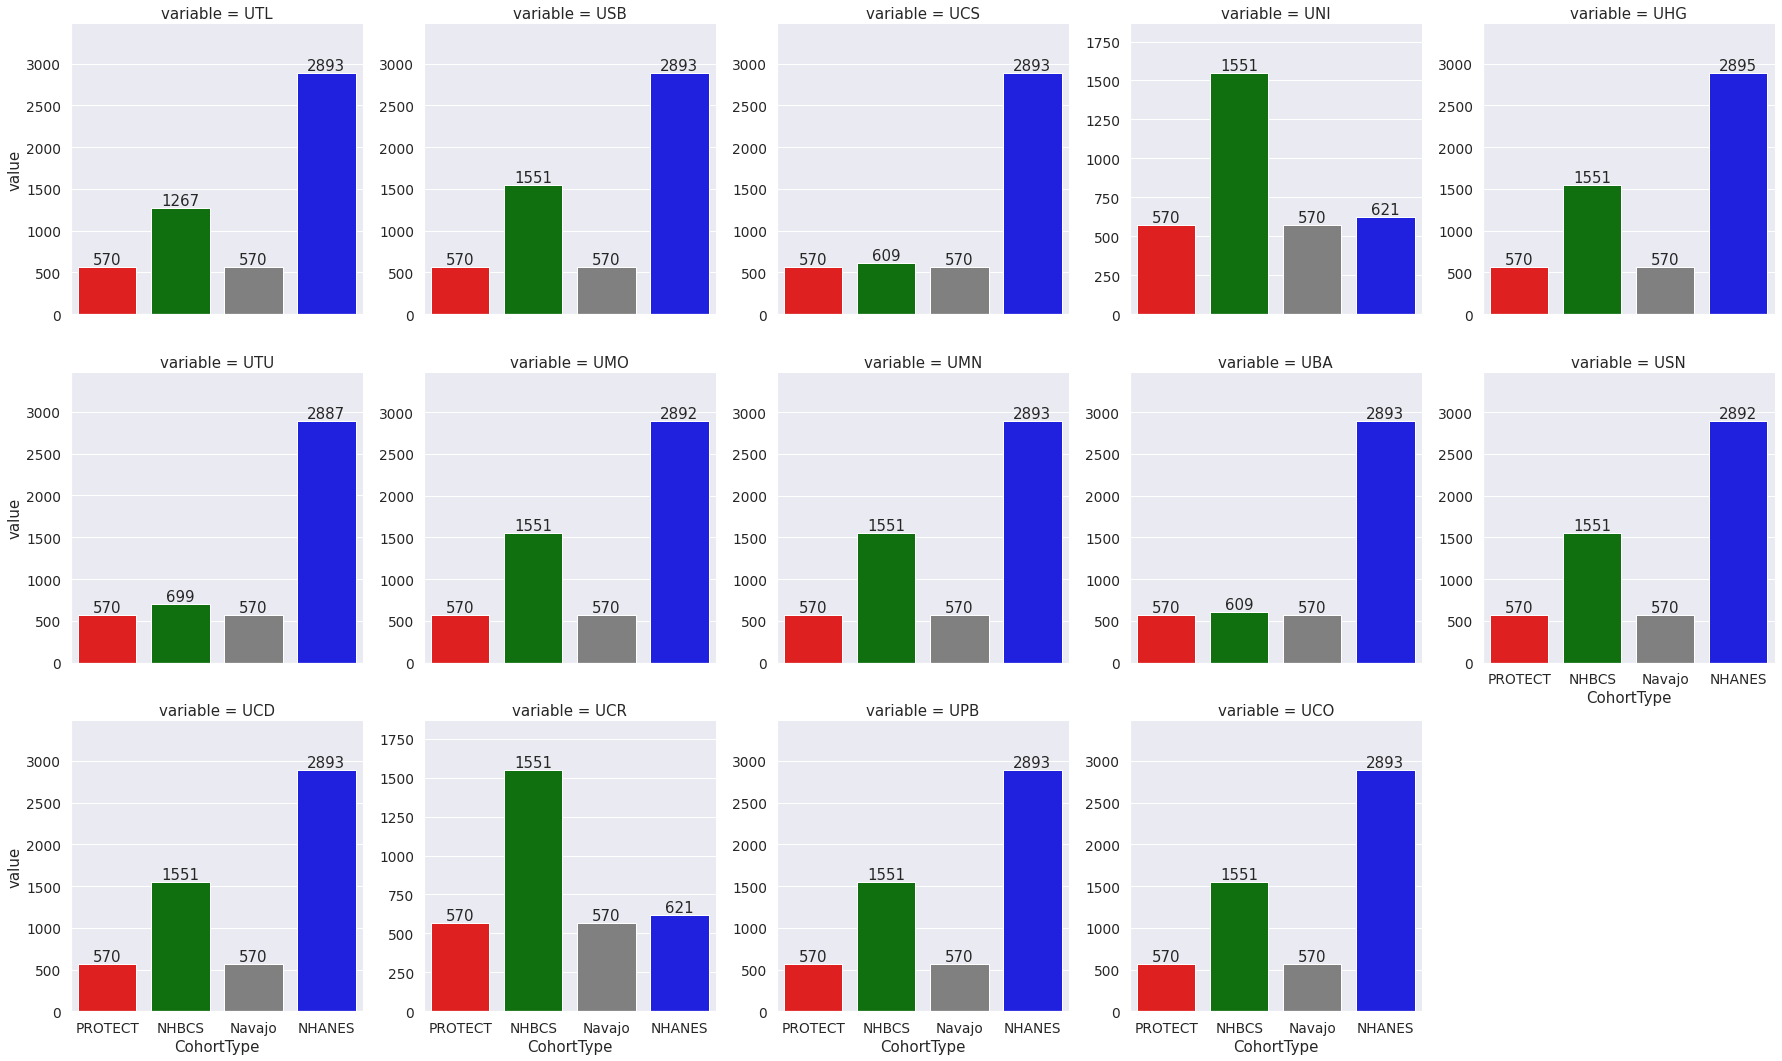

In [126]:
hist(counts_melted,  ['red', 'green', 'gray', 'blue'], 'Analyte_Counts_Hist_DP_Paper.jpg')

**Creating LOD Ratio graphs**

In [127]:
## returns if string is substring in any element of list
def list_contains(sub, lst):
    answer = False
    for col in lst:
        answer = answer or (col in lst)
    return answer

In [128]:
##round the columns of the df to specified number of digits
def round_cols_float(df, dec_places):
    df_temp =df.copy()
    for col in df_temp.columns:
        if col not in ['PIN_Patient', 'TimePeriod', 'CohortType']:
            df_temp[col] =df_temp[col].apply(lambda x: round(x, dec_places))
    return df_temp

In [129]:
##helper to build df for lod
def lod_helper(df, intersec, coh_name, cohs_acc, var_acc, val_acc, denom_acc, col_ending):
    for col in intersec:
        if col +col_ending in df.columns:
            cohs_acc.append(coh_name)
            var_acc.append(col )
            val_acc.append(len(df[df[col + col_ending] == 0.0][col +col_ending]))
            denom_acc.append(len(df[col+col_ending]) - sum(df[col + col_ending].isna()))
    return cohs_acc, var_acc, val_acc, denom_acc

In [130]:
df_NHANES_blod.head()

Analyte,PIN_Patient,TimePeriod,UALB_mg,UALB_ug,UBA,UCD,UCO,UCR,UCRT_mg,UCRT_umol,...,UI,UMN,UMO,UNI,UPB,USB,USN,UTL,UTU,CohortType
0,62161,2011-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NHANES
1,62169,2011-12,NaN,NaN,5.400000e-79,5.400000e-79,5.400000e-79,NaN,NaN,NaN,...,NaN,5.400000e-79,5.400000e-79,NaN,5.400000e-79,1.000000e+00,5.400000e-79,5.400000e-79,5.400000e-79,NHANES
2,62176,2011-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NHANES
3,62180,2011-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NHANES
4,62184,2011-12,NaN,NaN,5.400000e-79,5.400000e-79,5.400000e-79,NaN,NaN,NaN,...,NaN,5.400000e-79,5.400000e-79,NaN,5.400000e-79,5.400000e-79,5.400000e-79,5.400000e-79,5.400000e-79,NHANES


In [131]:

cohs = []
var = []
val = []

cohs_acc, var_acc, val_acc, denom_acc = lod_helper(df_NEU_blod, intersec_cols, NEU_alias, [], [], [], [], '' )
cohs_acc, var_acc, val_acc, denom_acc = lod_helper(df_DAR_blod, intersec_cols, DAR_alias, cohs_acc, var_acc, val_acc, denom_acc, '_BLOD')
cohs_acc, var_acc, val_acc, denom_acc = lod_helper(df_UNM_blod, intersec_cols, UNM_alias, cohs_acc, var_acc, val_acc, denom_acc, '')
df_NHANES_blod_float = round_cols_float(df_NHANES_blod, 2)
cohs_acc, var_acc, val_acc, denom_acc = lod_helper(df_NHANES_blod_float, intersec_cols, NHANES_alias, cohs_acc, var_acc, val_acc, denom_acc, '')

blod_counts_melted ={'CohortType':  cohs_acc, 'variable': var_acc, 'value': val_acc, 'N' : denom_acc}
blod_df = pd.DataFrame(data = blod_counts_melted)

In [132]:
df_NEU_blod = df_NEU_blod[df_NEU_blod['TimePeriod']==2]


In [133]:
blod_df[blod_df['CohortType']==NEU_alias].head(5)

,CohortType,variable,value,N
0,PROTECT,UTL,257,570
1,PROTECT,USB,436,570
2,PROTECT,UCS,570,570
3,PROTECT,PIN_Patient,0,570
4,PROTECT,TimePeriod,0,570


In [134]:
counts

,UTL,USB,UCS,UNI,UHG,UTU,UMO,UMN,UBA,USN,UCD,UCR,UPB,UCO,CohortType
0,570,570,570,570,570,570,570,570,570,570,570,570,570,570,PROTECT
1,1267,1551,609,1551,1551,699,1551,1551,609,1551,1551,1551,1551,1551,NHBCS
2,570,570,570,570,570,570,570,570,570,570,570,570,570,570,Navajo
3,2893,2893,2893,621,2895,2887,2892,2893,2893,2892,2893,621,2893,2893,NHANES


In [135]:
blod_df[blod_df['CohortType']==DAR_alias].head(5)

,CohortType,variable,value,N
17,NHBCS,UTL,1178,2152
18,NHBCS,USB,1099,2152
19,NHBCS,UCS,1556,2152
20,NHBCS,UNI,1003,2152
21,NHBCS,UHG,1261,2152


In [136]:
blod_df[blod_df['CohortType']==UNM_alias].head(5)

,CohortType,variable,value,N
31,Navajo,UTL,257,570
32,Navajo,USB,436,570
33,Navajo,UCS,570,570
34,Navajo,PIN_Patient,0,570
35,Navajo,TimePeriod,0,570


In [137]:
blod_df[blod_df['CohortType']==NHANES_alias].head(5)

,CohortType,variable,value,N
48,NHANES,UTL,2882,2893
49,NHANES,USB,2179,2893
50,NHANES,UCS,2892,2893
51,NHANES,PIN_Patient,0,8652
52,NHANES,TimePeriod,0,8652


In [138]:
##modifying blod_df to be percent of 0.0 values over all non-na values
blod_df_ratio = blod_df.copy()
blod_df_ratio['value'] = round(blod_df_ratio['value']/blod_df_ratio['N'],2)
m_blod_df_ratio = blod_df_ratio[~blod_df_ratio['variable'].isin(['CohortType', 'PIN_Patient', 'TimePeriod'])]

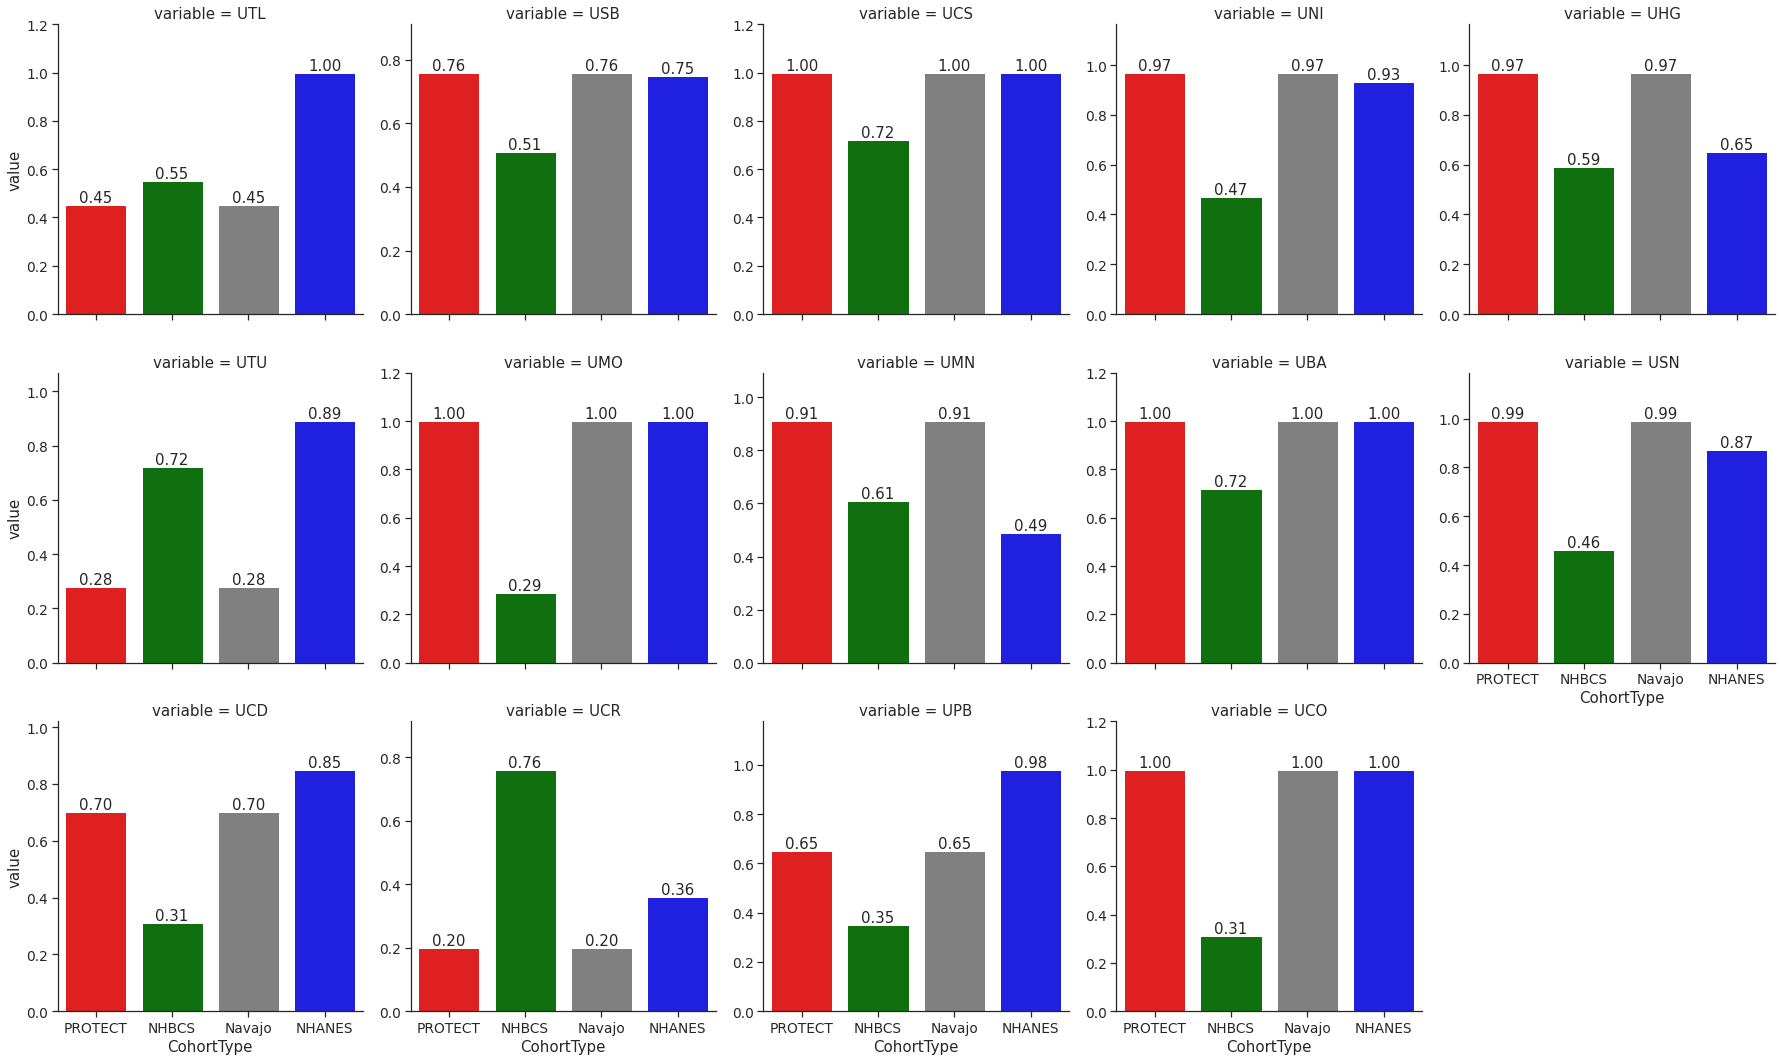

In [139]:
sns.set_style('ticks')

g = sns.catplot(
    data = m_blod_df_ratio,
    x = 'CohortType', y = 'value',
    col ='variable', kind = 'bar', col_wrap = 5, sharey = False, palette = ['red', 'green', 'gray', 'blue']
)
# iterate through axes and set bar label as number of datapoints
for ax in g.axes.ravel():

    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()):.2f}' for v in c]
        ax.bar_label(c, labels=labels, label_type = 'edge')
    ax.margins(y = 0.2)

g.savefig('Above_LOD_Ratio_Hist_DP_Paper.jpg', format ='jpeg', dpi =1000)

**Creating Graph of Distributions**

In [140]:
##creating dataframe to create a boxplot
def long_on_analyte(df_neu, df_dar, df_unm, df_nhanes, intersec_cols):
    cols = intersec_cols.copy()
    cols.remove('PIN_Patient')
    cols.remove('TimePeriod')
    neu_ints_melt = pd.melt(df_neu[cols], id_vars = "CohortType")
    dar_ints_melt = pd.melt(df_dar[cols], id_vars = "CohortType")
    unm_ints_melt = pd.melt(df_unm[cols], id_vars = "CohortType")
    nhanes_ints_melt = pd.melt(df_nhanes[cols], id_vars = "CohortType")
    return pd.concat([neu_ints_melt, dar_ints_melt, unm_ints_melt, nhanes_ints_melt], axis = 0)

In [141]:
all_combined_stacks_melts = long_on_analyte(df_NEU, df_DAR, df_UNM, df_NHANES, intersec_cols)
all_combined_stacks_melts

,CohortType,Analyte,value,variable
0,PROTECT,USB,0.186127,NaN
1,PROTECT,USB,0.217456,NaN
2,PROTECT,USB,0.120617,NaN
3,PROTECT,USB,0.121765,NaN
4,PROTECT,USB,0.153759,NaN
...,...,...,...,...
120157,NHANES,NaN,NaN,UPB
120158,NHANES,NaN,NaN,UPB
120159,NHANES,NaN,0.170000,UPB
120160,NHANES,NaN,0.550000,UPB


In [142]:
import math
i =0
while i < len(all_combined_stacks_melts):
    if type(all_combined_stacks_melts.iloc[i]['variable']) != str:
        all_combined_stacks_melts.at[i, 'variable'] = all_combined_stacks_melts.iloc[i]['Analyte'] 
    i = i+1
m_all_combined_stacks_melts = all_combined_stacks_melts[['CohortType', 'value', 'variable']]

In [143]:
m_all_combined_stacks_melts.head(5)

,CohortType,value,variable
0,PROTECT,0.186127,USB
1,PROTECT,0.217456,USB
2,PROTECT,0.120617,USB
3,PROTECT,0.121765,USB
4,PROTECT,0.153759,USB


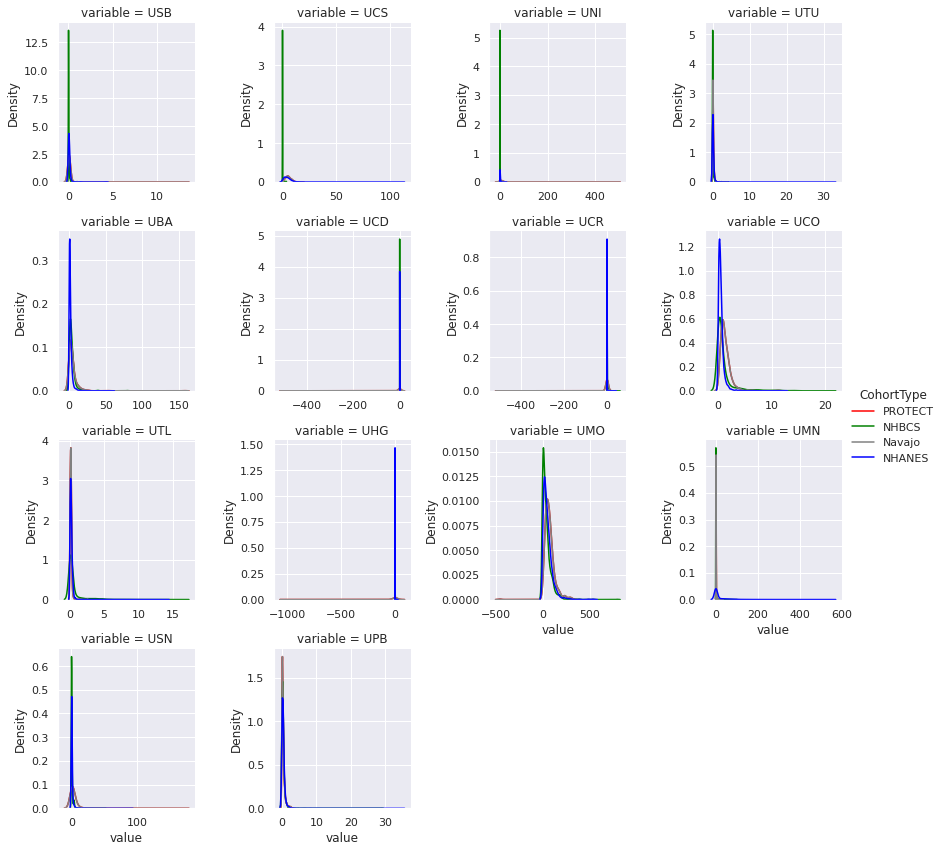

In [152]:
# Distribution Plot on Analyte
sns.set(font_scale = 1)
g = sns.FacetGrid(m_all_combined_stacks_melts, col = 'variable', hue = 'CohortType', col_wrap = 4, sharex = False, sharey = False, palette =  ['red', 'green', 'gray', 'blue'])
p1 = g.map(sns.kdeplot, 'value').add_legend()
##p1.savefig('Dist_Plot_DP_Paper.jpg', format = 'jpeg', dpi = 1000)
g

In [153]:
all_combined_stacks_melts_log = all_combined_stacks_melts.copy()
all_combined_stacks_melts_log = long_on_analyte(df_NEU_log, df_DAR_log, df_UNM_log, df_NHANES_log, intersec_cols)
all_combined_stacks_melts_log.head(5)

,CohortType,Analyte,value,variable
0,PROTECT,USB,-0.730192,NaN
1,PROTECT,USB,-0.662629,NaN
2,PROTECT,USB,-0.918591,NaN
3,PROTECT,USB,-0.914476,NaN
4,PROTECT,USB,-0.813160,NaN


In [154]:
all_combined_stacks_melts_log

,CohortType,Analyte,value,variable
0,PROTECT,USB,-0.730192,NaN
1,PROTECT,USB,-0.662629,NaN
2,PROTECT,USB,-0.918591,NaN
3,PROTECT,USB,-0.914476,NaN
4,PROTECT,USB,-0.813160,NaN
...,...,...,...,...
120157,NHANES,NaN,NaN,UPB
120158,NHANES,NaN,NaN,UPB
120159,NHANES,NaN,-0.769551,UPB
120160,NHANES,NaN,-0.259637,UPB


In [155]:
import math
i =0
while i < len(all_combined_stacks_melts_log):
    if type(all_combined_stacks_melts_log.iloc[i]['variable']) != str:
        all_combined_stacks_melts_log.at[i, 'variable'] = all_combined_stacks_melts_log.iloc[i]['Analyte'] 
    i = i+1
m_all_combined_stacks_melts_log = all_combined_stacks_melts_log[['CohortType', 'value', 'variable']]

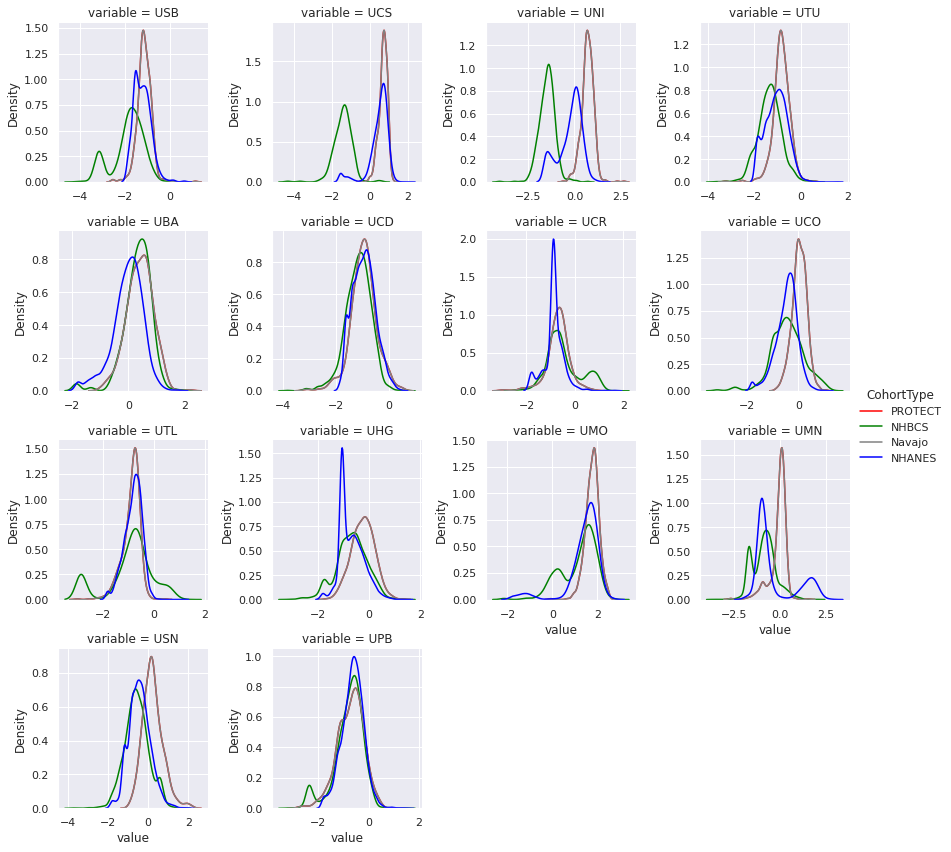

In [156]:
# Distribution Plot on log analyte value

g = sns.FacetGrid(m_all_combined_stacks_melts_log, col = 'variable', hue = 'CohortType', col_wrap = 4, sharex = False, sharey = False, palette =  ['red', 'green', 'gray', 'blue'])
p1 = g.map(sns.kdeplot, 'value').add_legend()
p1.savefig('Dist_Plot_Log_Analyte_DP_Paper.jpg', format = 'jpeg', dpi = 1000)

**Creating Boxplots**

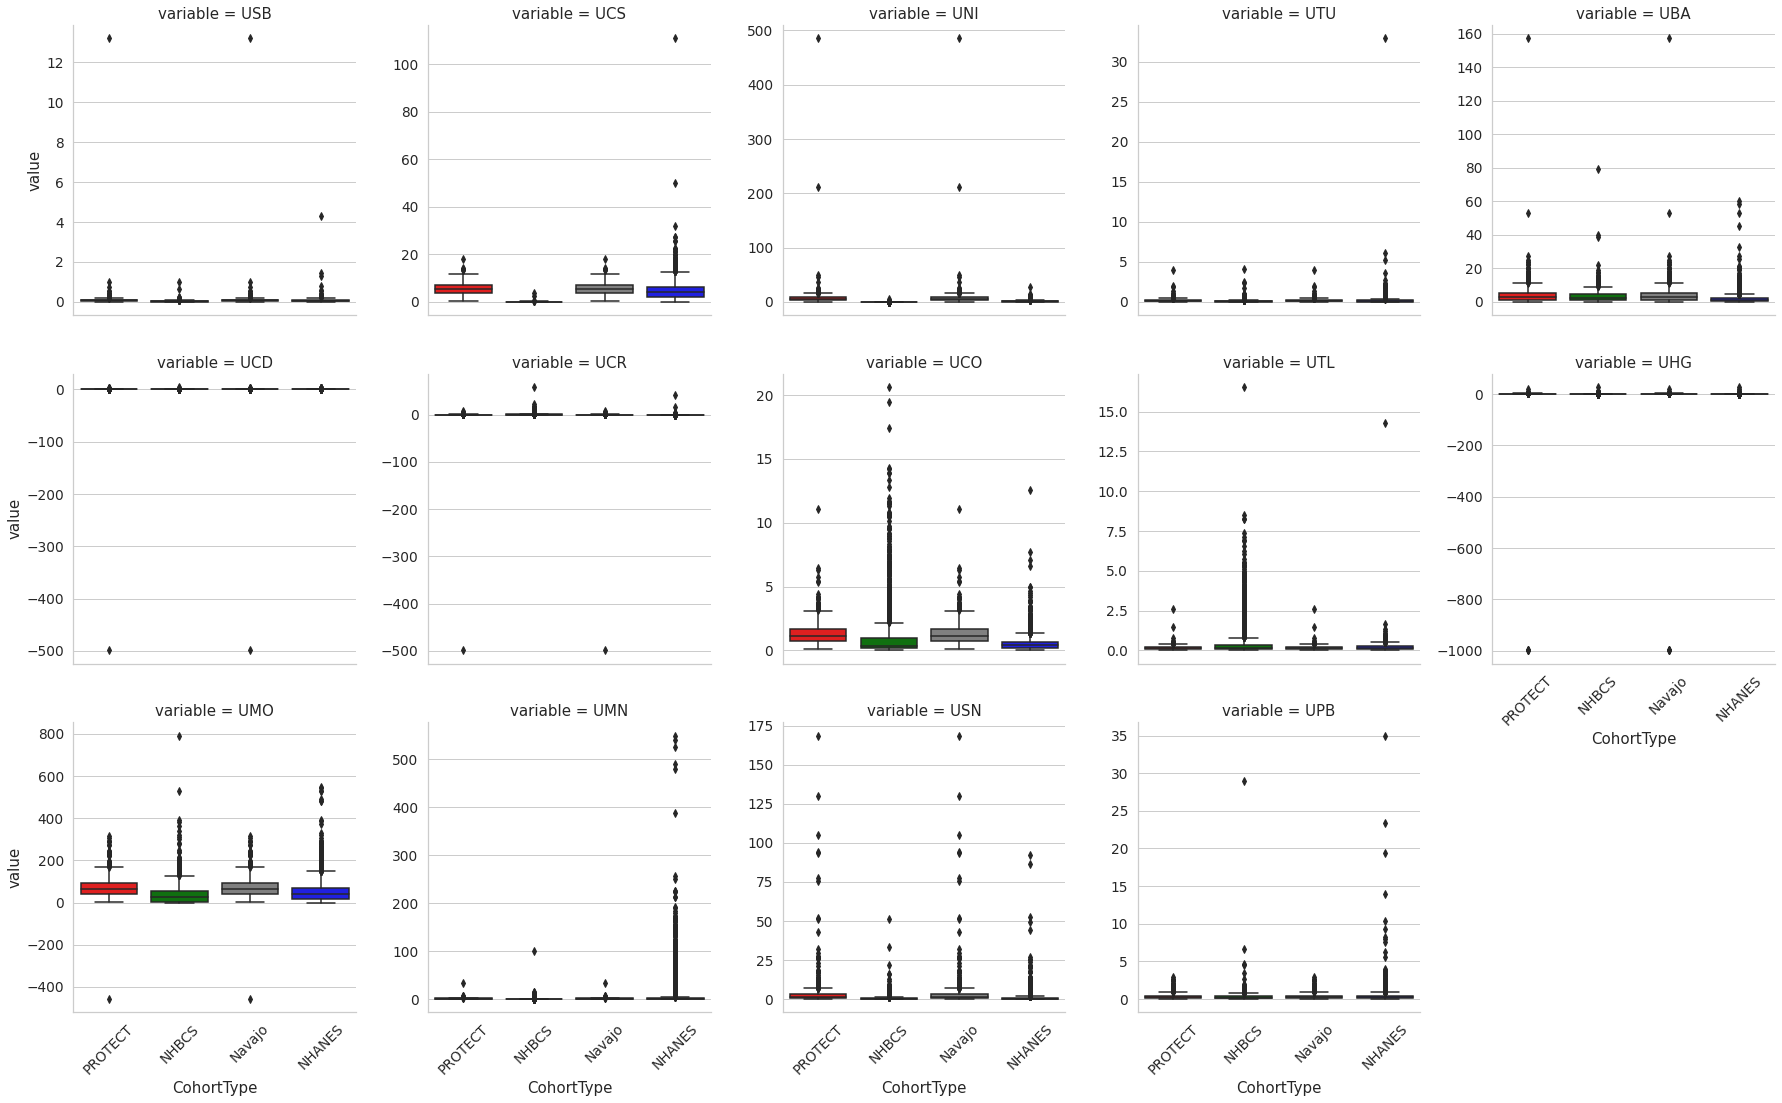

In [149]:
##boxplopts on analyte value
sns.set_style('whitegrid')

plot_df = all_combined_stacks_melts[all_combined_stacks_melts['CohortType'].isin([NEU_alias,DAR_alias,UNM_alias, NHANES_alias])]
g = sns.catplot(
    data = plot_df,
    x = 'CohortType', y ='value',
    col ='variable', kind ='box', col_wrap = 5, sharey = False, palette =  ['red', 'green', 'gray', 'blue'])

# set rotation
g.set_xticklabels(rotation=45)

g.savefig('Boxplots_DP_Paper.jpg', format = 'jpeg', dpi = 500)

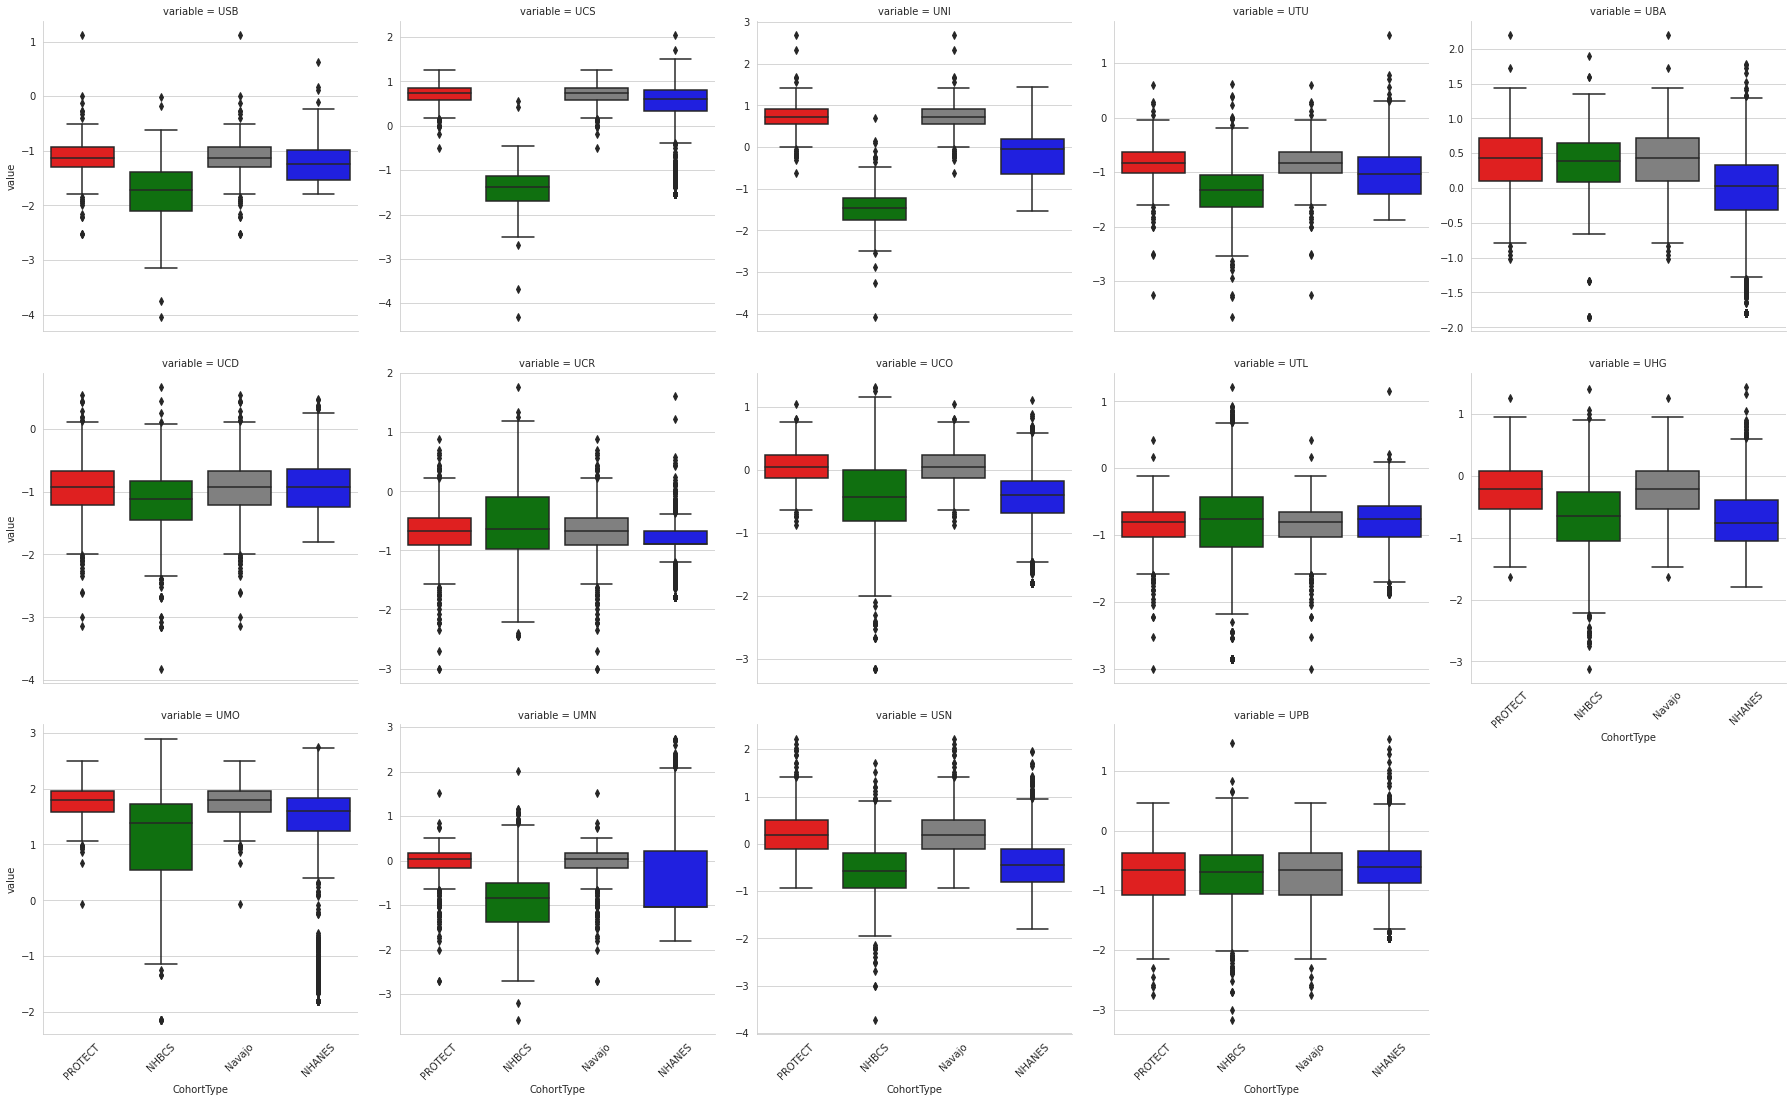

In [110]:
##boxplopts on log analyte value
sns.set_style('whitegrid')

plot_log_df= all_combined_stacks_melts_log[all_combined_stacks_melts_log['CohortType'].isin([NEU_alias,DAR_alias,UNM_alias, NHANES_alias])]
g = sns.catplot(
    data = plot_log_df,
    x = 'CohortType', y ='value',
    col ='variable', kind ='box', col_wrap = 5, sharey = False, palette =  ['red', 'green', 'gray', 'blue'])

# set rotation
g.set_xticklabels(rotation=45)
g.savefig('Boxplots_Log_Analyte_DP_Paper.jpg', format = 'jpeg', dpi = 500)

**One-Way Anova of Geometric Means**

Meeting assumptions

1. Normally distributed: over 30 datapoints so Central Limit Theorem says they are normally distributed
2. Independent Groups: met by structure of data
3. Homogeneity of Variances (equal variances): will be tested for each analyte group

Source: https://online.stat.psu.edu/stat200/lesson/10/10.2

In [113]:
import statistics as stat
from scipy.stats import f_oneway
from statistics import variance

##get colors to print in color
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

##conduct a one way anova of all analytes
def one_way_anova(df_all, fi_name, intersec):
    ##define lists that report results of anova
    analytes = []
    assumptions = []
    p_vals = []
    sig = []
    variances = []

    for col in intersec:
        if col not in ['TimePeriod', 'CohortType', 'PIN_Patient']:
            analytes.append(col)
            ##get series of analyte values w/out NaN
            NEU = df_ALL[df_ALL['CohortType'] == NEU_alias][col].dropna()
            UNM = df_ALL[df_ALL['CohortType'] == UNM_alias][col].dropna()
            DAR = df_ALL[df_ALL['CohortType'] == DAR_alias][col].dropna()
            NHANES = df_ALL[df_ALL['CohortType'] == NHANES_alias][col].dropna()
            var = [round(variance(NEU),3), round(variance(DAR),3), round(variance(UNM),3), round(variance(NHANES),3)]
            variances.append(var)
            ##if equal variances, conduct anova
            ##if round(variance(NEU), 2) == round(variance(UNM), 2) == round(variance(DAR), 2) == round(variance(NHANES), 2):
            if max(var) / min(var) < 2:
                print(bcolors.OKGREEN + col, "passes assumptions" + bcolors.OKGREEN, '\n')
                assumptions.append(True)

            else:                     
                print(bcolors.FAIL + col, "fails: unequal variances" + bcolors.FAIL)
                assumptions.append(False)
                    #perform one-way ANOVA
            p = f_oneway(NEU , UNM ,DAR , NHANES).pvalue
            p_vals.append(p)
            if p > 0.05:
                sig.append(False)
            else:
                sig.append(True)
    ##make df from results of anova
    data = {'Analytes' : analytes, 'Passes Equal Variance Assumption' : assumptions, 'P-Value' : p_vals, 
            'Significant' : sig, 'Variance' : variances}
    res_df = pd.DataFrame(data)
    res_df.to_csv(fi_name, index = False)
    return res_df

In [114]:
anova_df = one_way_anova(df_ALL, 'one_way_anova_results.csv', intersec_cols)
anova_df

UBA fails: unequal variances
UCD fails: unequal variances
UPB fails: unequal variances
UMO passes assumptions 

UCS fails: unequal variances
UTL fails: unequal variances
UCO fails: unequal variances
UHG fails: unequal variances
USN fails: unequal variances
UMN fails: unequal variances
USB fails: unequal variances
UTU fails: unequal variances


,Analytes,Passes Equal Variance Assumption,P-Value,Significant,Variance
0,UBA,False,1.978335e-39,True,"[63.962, 22.753, 561.305, 9.117]"
1,UCD,False,3.310220e-40,True,"[0.11, 0.02, 0.105, 0.063]"
2,UPB,False,2.654738e-03,True,"[0.177, 0.674, 0.327, 1.088]"
3,UMO,True,8.046077e-17,True,"[2526.62, 2668.436, 2660.817, 2618.08]"
4,UCS,False,7.718397e-05,True,"[6.495, 11.995, 10.861, 15.267]"
5,UTL,False,3.749949e-34,True,"[0.023, 0.022, 0.01, 0.021]"
6,UCO,False,8.837529e-150,True,"[0.94, 0.516, 1.109, 0.348]"
7,UHG,False,1.350979e-47,True,"[1.754, 0.643, 0.317, 0.884]"
8,USN,False,1.449629e-54,True,"[168.895, 4.468, 72.545, 11.596]"
9,UMN,False,1.382534e-75,True,"[2.297, 7.601, 115.566, 1476.996]"


In [115]:
anova_df_log = one_way_anova(df_ALL_log, 'log_one_way_anova_results.csv', intersec_cols_log)
anova_df_log

UBA fails: unequal variances
UCD fails: unequal variances
UPB fails: unequal variances
UMO passes assumptions 

UCS fails: unequal variances
UTL fails: unequal variances
UCO fails: unequal variances
UHG fails: unequal variances
USN fails: unequal variances
UMN fails: unequal variances
USB fails: unequal variances
UTU fails: unequal variances


,Analytes,Passes Equal Variance Assumption,P-Value,Significant,Variance
0,UBA,False,1.978335e-39,True,"[63.962, 22.753, 561.305, 9.117]"
1,UCD,False,3.310220e-40,True,"[0.11, 0.02, 0.105, 0.063]"
2,UPB,False,2.654738e-03,True,"[0.177, 0.674, 0.327, 1.088]"
3,UMO,True,8.046077e-17,True,"[2526.62, 2668.436, 2660.817, 2618.08]"
4,UCS,False,7.718397e-05,True,"[6.495, 11.995, 10.861, 15.267]"
5,UTL,False,3.749949e-34,True,"[0.023, 0.022, 0.01, 0.021]"
6,UCO,False,8.837529e-150,True,"[0.94, 0.516, 1.109, 0.348]"
7,UHG,False,1.350979e-47,True,"[1.754, 0.643, 0.317, 0.884]"
8,USN,False,1.449629e-54,True,"[168.895, 4.468, 72.545, 11.596]"
9,UMN,False,1.382534e-75,True,"[2.297, 7.601, 115.566, 1476.996]"


In [74]:
'''## One way Anova on log analyte values
import math
##get colors to print in color
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

##conduct a one way anova of all analytes
def one_way_anova_log(df_all):
    ##define lists that report results of anova
    analytes = []
    assumptions = []
    p_vals = []
    sig = []
    variances = []

    for col in df_all.columns:
        if col not in ['TimePeriod', 'CohortType', 'PIN_Patient']:
            analytes.append(col)
            NEU = df_ALL[df_ALL['CohortType']==NEU_alias].dropna(subset = [col])
            ##NEU = NEU[NEU[col] != 0.0]
            try:
            NEU = NEU[col].apply(lambda x : math.log(x, 10))
            except:
            print(col)
            
            DAR = df_ALL[df_ALL['CohortType']==DAR_alias].dropna(subset = [col])
            ## DAR = DAR[DAR[col] != 0.0]
            DAR =DAR[col].apply(lambda x : math.log(x, 10))

            UNM = df_ALL[df_ALL['CohortType']==UNM_alias].dropna(subset = [col])
            ## UNM = UNM[UNM[col] != 0.0]
            UNM =UNM[col].apply(lambda x : math.log(x, 10))

            NHANES = df_ALL[df_ALL['CohortType']==NHANES_alias].dropna(subset = [col])
            ## NHANES = NHANES[NHANES[col] != 0.0]
            NHANES = NHANES[col].apply(lambda x : math.log(x, 10))
            
            var = [round(variance(NEU),3), round(variance(DAR),3), round(variance(UNM),3), round(variance(NHANES),3)]
            variances.append(var)
            if max(var) / min(var) < 2:
                print(bcolors.OKGREEN + col, "passes assumptions" + bcolors.OKGREEN, '\n')
                assumptions.append(True)

            else:                     
                print(bcolors.FAIL + col, "fails: unequal variances" + bcolors.FAIL)
                assumptions.append(False)
                    #perform one-way ANOVA
            p = f_oneway(NEU , UNM ,DAR , NHANES).pvalue
            p_vals.append(p)
            if p > 0.05:
                sig.append(False)
            else:
                sig.append(True)
    ##make df from results of anova
    data = {'Analytes' : analytes, 'Passes Equal Variance Assumption' : assumptions, 'P-Value' : p_vals, 
            'Significant' : sig, 'Variance' : variances}
    res_df = pd.DataFrame(data)
    res_df.to_csv('one_way_anova_log_results.csv', index = False)
    return res_df'''

'## One way Anova on log analyte values\nimport math\n##get colors to print in color\nclass bcolors:\n    HEADER = \'\x1b\'\n    OKBLUE = \'\x1b\'\n    OKCYAN = \'\x1b\'\n    OKGREEN = \'\x1b\'\n    WARNING = \'\x1b\'\n    FAIL = \'\x1b\'\n    ENDC = \'\x1b\'\n    BOLD = \'\x1b\'\n    UNDERLINE = \'\x1b\'\n\n##conduct a one way anova of all analytes\ndef one_way_anova_log(df_all):\n    ##define lists that report results of anova\n    analytes = []\n    assumptions = []\n    p_vals = []\n    sig = []\n    variances = []\n\n    for col in df_all.columns:\n        if col not in [\'TimePeriod\', \'CohortType\', \'PIN_Patient\']:\n            analytes.append(col)\n            NEU = df_ALL[df_ALL[\'CohortType\']==NEU_alias].dropna(subset = [col])\n            ##NEU = NEU[NEU[col] != 0.0]\n            try:\n            NEU = NEU[col].apply(lambda x : math.log(x, 10))\n            except:\n            print(col)\n            \n            DAR = df_ALL[df_ALL[\'CohortType\']==DAR_alias].dropna(

In [116]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
##post hoc tests on analytes that were found to be significantly different by ANOVA
##if p < 0.05,there is a statistically significant difference in means
def tukey(df_neu, df_dar, df_unm, df_nhanes, cols_to_test, fi_name):
    for col in cols_to_test:
        NEU = df_ALL[df_ALL['CohortType']==NEU_alias].dropna(subset = [col])
        DAR = df_ALL[df_ALL['CohortType']==DAR_alias].dropna(subset = [col])
        UNM = df_ALL[df_ALL['CohortType']==UNM_alias].dropna(subset = [col])
        NHANES = df_ALL[df_ALL['CohortType']==NHANES_alias].dropna(subset = [col])
        df = pd.concat([NEU, DAR, UNM, NHANES])
        tukey = pairwise_tukeyhsd(endog = df[col],
                                  groups = df['CohortType'],
                                  alpha=0.05)
        file_name = fi_name
        try:
            f = open(file_name, 'x')
            f = open(file_name, 'x')

        except:
            f = open(file_name, 'a')
            f.write(col + ' Tukey Result: \n')
            f.write(str(tukey))
            f.write('\n\n')

        f.close()
    return print(str(tukey))

In [117]:
cols_to_test = anova_df['Analytes']
tukey(df_NEU, df_DAR, df_UNM, df_NHANES, cols_to_test, 'tukey_results.csv')

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
NHANES   NHBCS  -0.0464 0.1777 -0.1053 0.0124  False
NHANES  Navajo  -0.0004    1.0 -0.0669 0.0661  False
NHANES PROTECT    0.029 0.6479 -0.0349  0.093  False
 NHBCS  Navajo   0.0461 0.4591 -0.0348 0.1269  False
 NHBCS PROTECT   0.0755  0.066 -0.0033 0.1543  False
Navajo PROTECT   0.0294 0.8084 -0.0552 0.1141  False
----------------------------------------------------


In [118]:
cols_to_test_log = anova_df_log['Analytes']
tukey(df_NEU_log, df_DAR_log, df_UNM_log, df_NHANES_log, cols_to_test_log, 'log_tukey_results.csv')

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
NHANES   NHBCS  -0.0464 0.1777 -0.1053 0.0124  False
NHANES  Navajo  -0.0004    1.0 -0.0669 0.0661  False
NHANES PROTECT    0.029 0.6479 -0.0349  0.093  False
 NHBCS  Navajo   0.0461 0.4591 -0.0348 0.1269  False
 NHBCS PROTECT   0.0755  0.066 -0.0033 0.1543  False
Navajo PROTECT   0.0294 0.8084 -0.0552 0.1141  False
----------------------------------------------------


In [83]:
'''##post hoc tests on log of analytes that were found to be significantly different by ANOVA
##if p < 0.05,there is a statistically significant difference in means

def tukey_log(df_neu, df_dar, df_unm, df_nhanes, cols_to_test):
    for col in cols_to_test:
        NEU = df_ALL[df_ALL['CohortType']==NEU_alias].dropna(subset = [col])
        ##NEU = NEU[NEU[col] != 0.0]
        NEU[col] = NEU[col].apply(lambda x : math.log(x, 10))
        DAR = df_ALL[df_ALL['CohortType']==DAR_alias].dropna(subset = [col])
        ##DAR = DAR[DAR[col] != 0.0]
        DAR[col] =DAR[col].apply(lambda x : math.log(x, 10))
        
        UNM = df_ALL[df_ALL['CohortType']==UNM_alias].dropna(subset = [col])
        ## UNM = UNM[UNM[col] != 0.0]
        UNM[col] =UNM[col].apply(lambda x : math.log(x, 10))
        
        NHANES = df_ALL[df_ALL['CohortType']==NHANES_alias].dropna(subset = [col])
        ## NHANES = NHANES[NHANES[col] != 0.0]
        NHANES[col] = NHANES[col].apply(lambda x : math.log(x, 10))
        
        df = pd.concat([NEU, DAR, UNM, NHANES])
        tukey = pairwise_tukeyhsd(endog = df[col],
                                  groups = df['CohortType'],
                                  alpha=0.05)
        file_name = 'tukey_log_results.csv'
        try:
            f = open(file_name, 'x')
            f = open(file_name, 'x')

        except:
            f = open(file_name, 'a')
            f.write(col + ' Tukey Result: \n')
            f.write(str(tukey))
            f.write('\n\n')

        f.close()
    return print(str(tukey))
'''

"##post hoc tests on log of analytes that were found to be significantly different by ANOVA\n##if p < 0.05,there is a statistically significant difference in means\n\ndef tukey_log(df_neu, df_dar, df_unm, df_nhanes, cols_to_test):\n    for col in cols_to_test:\n        NEU = df_ALL[df_ALL['CohortType']==NEU_alias].dropna(subset = [col])\n        ##NEU = NEU[NEU[col] != 0.0]\n        NEU[col] = NEU[col].apply(lambda x : math.log(x, 10))\n        DAR = df_ALL[df_ALL['CohortType']==DAR_alias].dropna(subset = [col])\n        ##DAR = DAR[DAR[col] != 0.0]\n        DAR[col] =DAR[col].apply(lambda x : math.log(x, 10))\n        \n        UNM = df_ALL[df_ALL['CohortType']==UNM_alias].dropna(subset = [col])\n        ## UNM = UNM[UNM[col] != 0.0]\n        UNM[col] =UNM[col].apply(lambda x : math.log(x, 10))\n        \n        NHANES = df_ALL[df_ALL['CohortType']==NHANES_alias].dropna(subset = [col])\n        ## NHANES = NHANES[NHANES[col] != 0.0]\n        NHANES[col] = NHANES[col].apply(lambda x :

**Kolmogorov-Smirnov Test**

Source: https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm

Note: Has this assumption been met - "Perhaps the most serious limitation is that the distribution must be fully specified. That is, if location, scale, and shape parameters are estimated from the data, the critical region of the K-S test is no longer valid. It typically must be determined by simulation."

In [119]:
##determining if two samples came from the same distribution
##determining what distribution a sample follows
def ks(df_all, col_to_test, fi_name):
    from scipy.stats import ks_2samp
    cohort1 = []
    cohort2 = []
    analyte = []
    p_vals = []
    
    for col in cols_to_test:
        for coh1 in [NEU_alias,UNM_alias, DAR_alias, NHANES_alias]:
            for coh2 in  [NEU_alias,UNM_alias, DAR_alias, NHANES_alias]:
                if coh1 != coh2:
                    ##p < 0.05, data does NOT follow that distribution
                    ##alternative option set to two sided means null hypothesis is that d1 = d2
                    p_val = ks_2samp(df_ALL[df_ALL['CohortType'] == coh1].dropna(subset = [col])[col],
                                   df_ALL[df_ALL['CohortType'] == coh2].dropna(subset = [col])[col]).pvalue
                    cohort1.append(coh1)
                    cohort2.append(coh2)
                    p_vals.append(p_val)
                    analyte.append(col)
    res_df = pd.DataFrame(data = {'Cohort1' : cohort1, 'Cohort2' : cohort2, 'Analyte' : analyte, 'P-Value' : p_vals})
    res_df['distribution matches'] = res_df['P-Value'].map(lambda p : p > 0.05 )
    res_df.to_csv(fi_name, index = False)
    return res_df


In [120]:
df_ks = ks(df_ALL, cols_to_test, 'ks_test_results.csv')

In [121]:
df_ks_log = ks(df_ALL_log, cols_to_test, 'log_ks_test_results.csv')

In [90]:
'''##determining if two samples came from the same distribution
##determining what distribution a sample follows
def ks_log(df_all, col_to_test):
    from scipy.stats import ks_2samp
    cohort1 = []
    cohort2 = []
    analyte = []
    p_vals = []
    
    for col in cols_to_test:
        for coh1 in [NEU_alias,UNM_alias, DAR_alias, NHANES_alias]:
            for coh2 in  [NEU_alias,UNM_alias, DAR_alias, NHANES_alias]:
                if coh1 != coh2:
                    ##p < 0.05, data does NOT follow that distribution
                    ##alternative option set to two sided means null hypothesis is that d1 = d2
                    df1 = df_ALL[df_ALL['CohortType']==coh1].dropna(subset = [col])
                    ## df1 = df1[df1[col] != 0.0]
                    df1[col] = df1[col].apply(lambda x : math.log(x, 10))
                    df2 = df_ALL[df_ALL['CohortType']==coh2].dropna(subset = [col])
                    ## df2 = df2[df2[col] != 0.0]
                    df2[col] = df2[col].apply(lambda x : math.log(x, 10))
                    p_val = ks_2samp(df1[col],
                                   df2[col]).pvalue
                    cohort1.append(coh1)
                    cohort2.append(coh2)
                    p_vals.append(p_val)
                    analyte.append(col)
    res_df = pd.DataFrame(data = {'Cohort1' : cohort1, 'Cohort2' : cohort2, 'Analyte' : analyte, 'P-Value' : p_vals})
    res_df['distribution matches'] = res_df['P-Value'].map(lambda p : p > 0.05 )
    res_df.to_csv('ks_test_log_results.csv', index = False)
    return res_df'''
